# Example on Bejing Air Pullotion Data Set 

Example and preprocessing code is taken from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/, which is a tutorial that shows how to implement LSTMs in Keras. Here we going implement a similar model in pytorch.

Import libraries and basic preprocessing

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from torch.autograd import Variable 
from torch.nn import MSELoss
import torch.optim as optim
import torch.nn.functional as F

# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

df = pd.read_csv('data/air_pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], 
                      index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)
# manually specify column names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'
# mark all NA values with 0
df['pollution'].fillna(0, inplace=True)
# drop the first 24 hours since it includes NA values
df = df[24:]
# summarize first rows
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


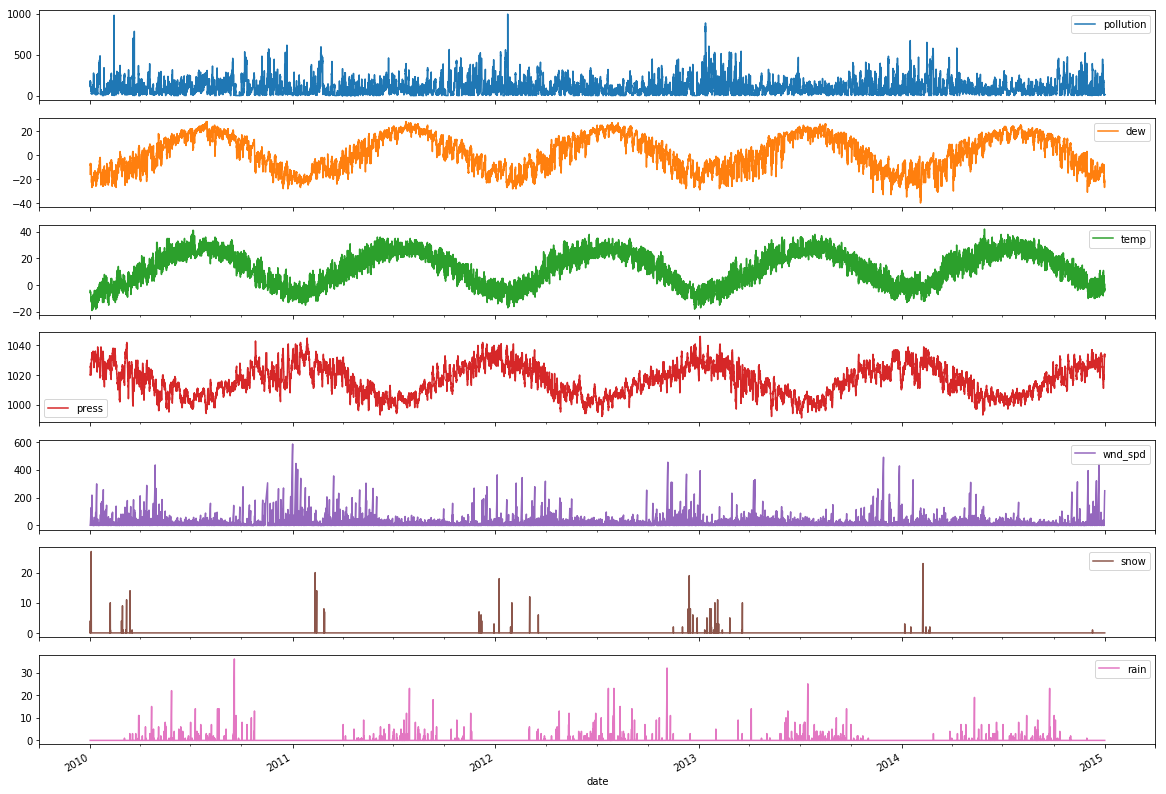

In [2]:
df.plot(subplots=True, figsize=(20,15))
plt.show()

Further preprocessing to convert the problem into a supervised time series prediction problem.
The code below extract lags for each variable.
After preprocessing the goal is to predict air pollution base on last hours weather and air pullotion. 

In [3]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_hours = 3
n_features = 8
reframed = series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var1(t-1),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.159960,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.182093,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.138833,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.109658,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.105634,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0


## Feed Forward Neural Network

In [4]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

We delete the columns for the current weather and use the current airpollution (var8(t)) as target 

In [5]:
# split into input and outputs
n_obs = n_hours * n_features
X_train, y_train = torch.Tensor(train[:, :n_obs]), torch.Tensor(train[:, -n_features]).view(n_train_hours, 1)
X_test, y_test = test[:, :n_obs], test[:, -n_features]
print(X_train.size(), y_train.size())

(torch.Size([8760, 24]), torch.Size([8760, 1]))


In [6]:
# create network class here
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FFNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FFNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(self.input_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, 1)
    
    def forward(self, x):
        hidden_state = F.relu(self.i2h(x))
        return self.h2o(hidden_state)


#### Main Training loop:
1. specifiy parameters, optimizer, loss function and model
2. split training data into mini-batches (inner for loop)
3. repeat scanning the whole data set num_epochs-times

In [7]:
#from models import FFNet

# specify parameters
num_epochs = 10
batch_size = 30
input_size = 24
hidden_size = 64

# initialize the model
model = FFNet(input_size, hidden_size)

# specify gradient optimizer and loss function
optimizer = optim.SGD(params=model.parameters(), lr=0.001, weight_decay=0)
criterion = MSELoss()

for epoch in range(num_epochs):
    for i in range(0,X_train.size()[0], batch_size):
        indices = range(i,i+batch_size)        
        # convert to Variable
        input_batch, target_batch = Variable(X_train[indices]), Variable(y_train[indices])
        
        optimizer.zero_grad()
        outputs = model(input_batch)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()
    print('Epoch {} with loss {}'.format(epoch+1, loss.data.numpy()))

Epoch 1 with loss 0.00129942793865
Epoch 2 with loss 0.00105039926711
Epoch 3 with loss 0.00102121464442
Epoch 4 with loss 0.00101330864709
Epoch 5 with loss 0.0010069119744
Epoch 6 with loss 0.000999713083729
Epoch 7 with loss 0.000991926062852
Epoch 8 with loss 0.000983825419098
Epoch 9 with loss 0.000975691189524
Epoch 10 with loss 0.000967843690887


In [8]:
# evaluate 
input_test =  Variable(torch.Tensor(X_test))
yhat = model(input_test)

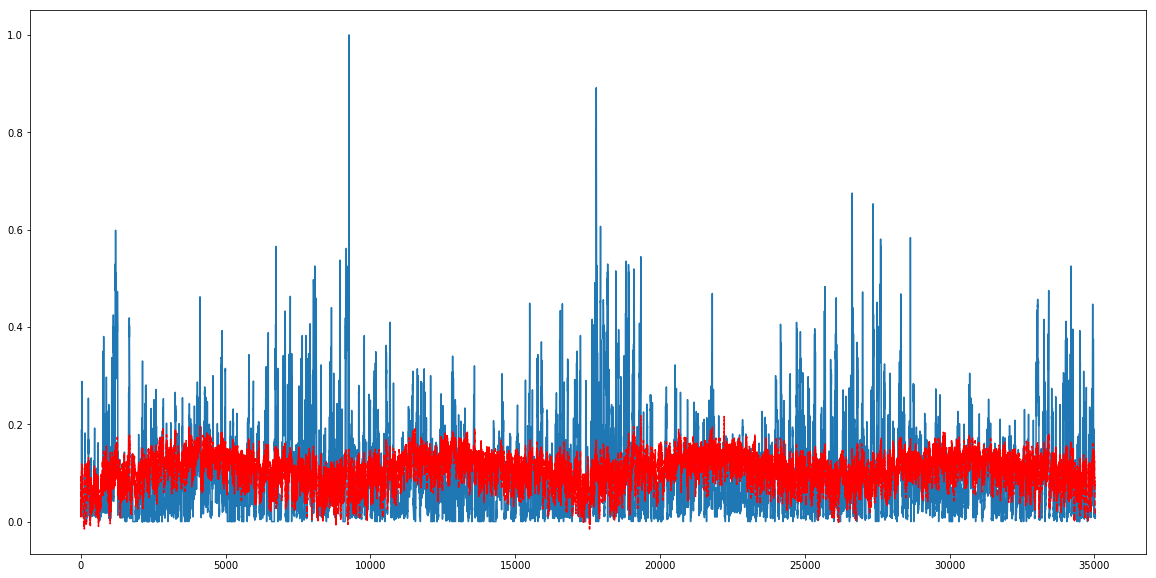

In [9]:
t = range(0, y_test.shape[0])
plt.figure(figsize=(20,10))
plt.plot(t, y_test)
plt.plot(t, yhat.data.numpy(), '--r')
plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error as MAE
MAE(y_test, yhat.data.numpy())    

0.06424376

## LSTM
An LSTM in pytorch takes a three dimensional tensor as an input. Since we have specified batch_first=True in the LSTM class the order is as follows: ``` [sequence_length, num_sequences, num_features] ```. As we only deal with one Time Series and not with multiple sequences, the second Dimension is set to 1.

In [17]:
# reshape input to be 3D tensors [sequence_length, num_sequences, num_features]
X_train = torch.Tensor(X_train).view((X_train.shape[0], 1, X_train.shape[1]))
X_test = torch.Tensor(X_test).view((X_test.shape[0], 1, X_test.shape[1]))
y_train, y_test = torch.Tensor(y_train).view(y_train.shape[0],1), torch.Tensor(y_test).view(y_test.shape[0],1)
print(X_train.size(), y_train.size(), X_test.size(), y_test.size())

RuntimeError: invalid argument 2: size '[8760 x 1 x 1]' is invalid for input with 210240 elements at /pytorch/aten/src/TH/THStorage.c:41

In [12]:
from models import LSTM
from torch.autograd import Variable 
from torch.nn import MSELoss
import torch.optim as optim
import torch.nn.functional as F

# parameters
num_epochs = 10
batch_size = 30
input_size = 24
hidden_size = 64
model = LSTM(input_size, hidden_size)
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0)
criterion = MSELoss()

In [13]:
model.train()

for epoch in range(num_epochs):
    for i in range(0, X_train.size()[0], batch_size):
        indices = range(i,i+batch_size)
        input_batch, target_batch = Variable(X_train[indices]), Variable(y_train[indices])
        optimizer.zero_grad()
        outputs = model(input_batch)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()
    print('Epoch {} with loss {}'.format(epoch+1, loss.data.numpy()))

Epoch 1 with loss 0.000326004461385
Epoch 2 with loss 0.000637983146589
Epoch 3 with loss 0.000233402883168
Epoch 4 with loss 7.6867552707e-05
Epoch 5 with loss 2.78253264696e-05
Epoch 6 with loss 9.07852881937e-06
Epoch 7 with loss 1.1623282262e-05
Epoch 8 with loss 1.82475978363e-05
Epoch 9 with loss 4.01461875299e-05
Epoch 10 with loss 3.61288621207e-05


In [14]:
model.eval()
yhat = model(Variable(X_test))

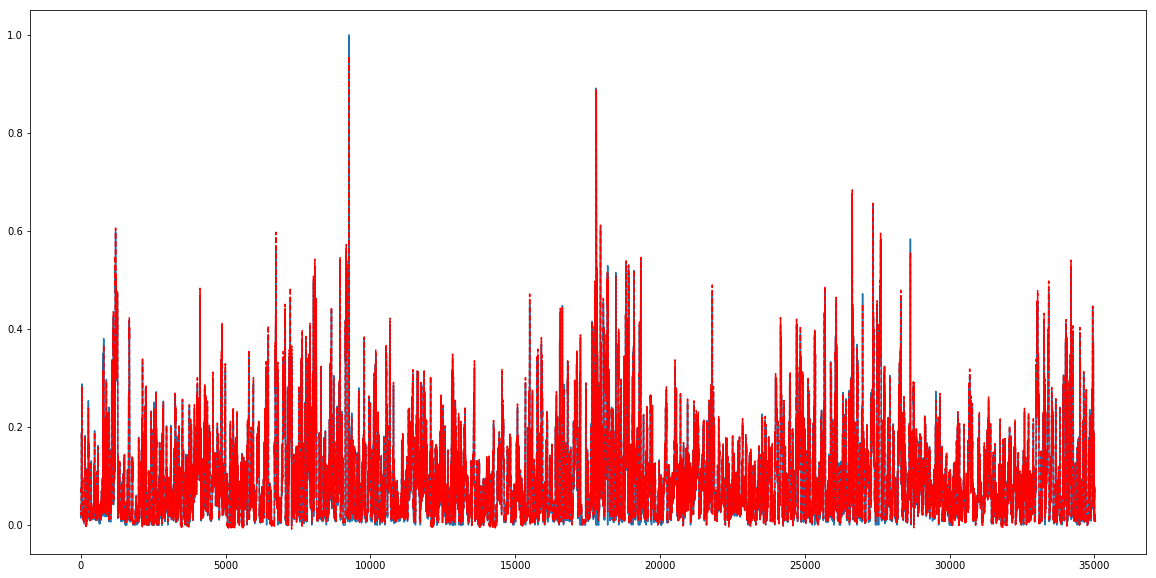

In [15]:
t = range(0, y_test.size()[0])
plt.figure(figsize=(20,10))
plt.plot(t, y_test.data.numpy())
plt.plot(t, yhat.data.numpy(), '--r')
plt.show()

In [16]:
print MAE(y_test, yhat.data.numpy()) 

0.003129697
